In [1]:
import numpy as np
import qililab as ql

import sys

sys.path.insert(1, "../utils")

from qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from qililab.utils import from_dict

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


api = API(ConnectionConfiguration(username="qat", api_key="meow"))

api.select_device_id(9)
ql.logger.setLevel(40)  # Set qililab's logger to a higher level so it only shows error messages

2024-03-08 18:05:45,852 - qm - INFO     - Starting session: 771a5da4-d759-48d8-a3b4-d711ed66e035


In [2]:
QUBIT = 0

In [3]:
runcard = api.get_runcard(runcard_name="galadriel_qprogram")
runcard_as_dict = runcard.runcard

RO_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["duration"]
RO_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["amplitude"]
X_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["duration"]
X_num_sigmas_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"]["num_sigmas"]
X_drag_coefficient_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"][
    "drag_coefficient"
]
X_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["amplitude"]

In [4]:
print(
    "drag params:\n \t amplitude",
    X_amplitude_runcard,
    "    duration",
    X_duration_runcard,
    "    drag coeff",
    X_drag_coefficient_runcard,
    "    sigmas",
    X_num_sigmas_runcard,
)
print("RO params:\n \t amplitude", RO_amplitude_runcard, "\t           duration", RO_duration_runcard)

drag params:
 	 amplitude 0.12946478254360685     duration 40     drag coeff -0.30264985249449683     sigmas 4
RO params:
 	 amplitude 0.0513 	           duration 2500


In [58]:
20_000 / 500, 10_000 / 250

(40.0, 40.0)

In [70]:
shots = 14000

wait_start = 0
wait_stop = 20_000
wait_step = 500


control_wf = ql.IQPair.DRAG(
    amplitude=0.5 * X_amplitude_runcard,  ## because it's a pi/2 pulse
    duration=X_duration_runcard,
    num_sigmas=X_num_sigmas_runcard,
    drag_coefficient=X_drag_coefficient_runcard,
)
readout_wf = ql.IQPair(
    I=ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
    Q=ql.Square(amplitude=0.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
)

time_of_flight = (
    200  ## approximate time it takes for the pulse to reach the set-up, before that we'll just measure noise.
)

acquisition_weights_duration = RO_duration_runcard
acquisition_weights = ql.IQPair(
    I=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
    Q=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
)

qubit_relaxation_duration = 200_000

In [71]:
qp = ql.QProgram(disable_autosync=True)
wait_variable = qp.variable(ql.Domain.Time)
with qp.average(shots=shots):
    with qp.for_loop(variable=wait_variable, start=wait_start, stop=wait_stop, step=wait_step):
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply Xpi/2 gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=wait_variable)  # wait
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply Xpi/2 gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=time_of_flight)  # wait for the RO pulse to get to the fridge
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=acquisition_weights.get_duration())  ## wait for data acquisition
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=qubit_relaxation_duration)  ## wait for qubit reinitialisation

        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait for first Xpi/2 pulse
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=wait_variable)  ## wait for wait time
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait second for Xpi/2 pulse
        qp.play(bus=f"readout_q{QUBIT}_bus", waveform=readout_wf, wait_time=time_of_flight)  ## send readout pulse
        qp.acquire(bus=f"readout_q{QUBIT}_bus", weights=acquisition_weights)  ## acquire data
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=qubit_relaxation_duration)  ## wait for qubit reinitialisation

full_qprogram = qp.to_dict()

In [72]:
result_id = api.execute(
    qprogram=full_qprogram,
    name="t2*",
    summary=f"timeofflight{time_of_flight}_waitstop{wait_stop}_waitstep{wait_step}_shots{shots}",
)[0]
print(result_id)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1709920893, time: 1709921146(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/circuits"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1709920893, time: 1709921146(leeway: 60)"}



9707


In [75]:
results = api.get_result(result_id)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1709921447, time: 1709921548(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/jobs/9707"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1709921447, time: 1709921548(leeway: 60)"}

Your job with id 9707 is completed.


In [76]:
qprogram_results = from_dict(results)

In [77]:
i_vec, q_vec = qprogram_results.results[f"readout_q{QUBIT}_bus"][0].array  ## i, q
v_vec = 20 * np.log10(np.sqrt(i_vec**2 + q_vec**2))

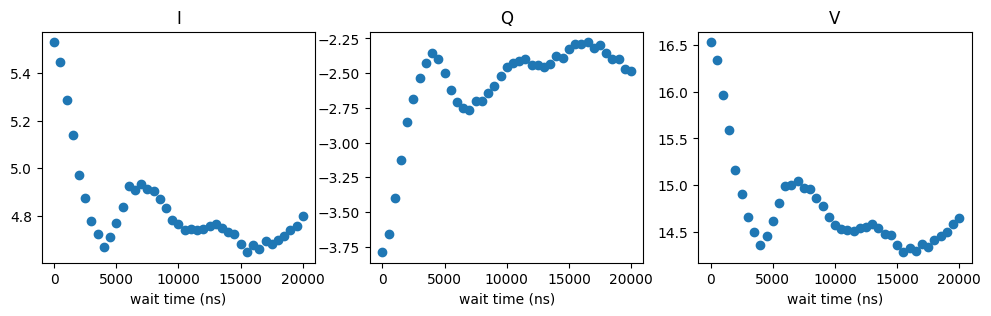

In [78]:
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
data = [i_vec, q_vec, v_vec]
titles = ["I", "Q", "V"]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.plot(xaxis, data[i], "o")
    ax.set_xlabel("wait time (ns)")
    ax.set_title(titles[i])

/home/ana/anaconda3/envs/alphatesting/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Optimized Parameters: [ 1.49621197  9.02911518 15.01321502  2.00000862]


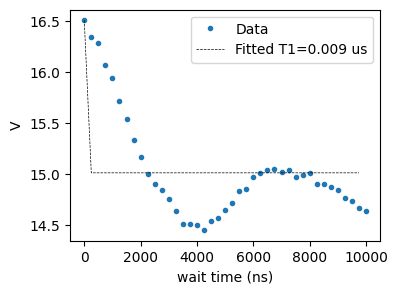

In [69]:
# Define the decaying exponential function
def damped_cosine(x, a, b, d, omega):
    return a * np.cos(omega * x) * np.exp(-1 / b * x) + d


xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
fit_up2 = -1  # 20
# Generate some sample data
x_data = xaxis[:fit_up2]
y_data = v_vec[:fit_up2]

# Fit the decaying exponential function to the data
initial_guess = [1, 2_000, 15, 2]  # initial guess for the parameters
optimized_params, _ = curve_fit(damped_cosine, x_data, y_data, p0=initial_guess)

# Print the optimized parameters
print("Optimized Parameters:", optimized_params)

# Plot the data and the fitted function
plt.figure(figsize=(4, 3))
plt.plot(xaxis, v_vec, "o", ms=3, label="Data")
plt.plot(
    x_data,
    damped_cosine(x_data, *optimized_params),
    "k--",
    lw=0.5,
    label=f"Fitted T1={optimized_params[1]/1000:.3f} us",
)
plt.legend()
plt.xlabel("wait time (ns)")
plt.ylabel("V")
plt.show()
T1_fit_ns = optimized_params[1]

In [ ]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")